# Making a single neuron and implementing back-propagation

The content of this cell is inspired in the following post: http://iamtrask.github.io/2015/07/12/basic-python-network/  , on this post a single neuron preditcs the output of a simple truth table.

What I want to explore is if a single neuron can predict the coefficients of a simple linear model of multiple inputs. I.e.
I will create a model function such as

\begin{equation}
Y = c1 * c1 + x2 * x2 + c3 * x3
\end{equation*}

Where _c1_, _c2_ and _c3_ are the coefficients that I want to learn.

This may sound a bit stupid after finishing playing with the code, but that was my initial goal anyway.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
plt.rcParams["figure.figsize"]=(6.5,4)

np.random.seed(1)

My neurons are implemented following the formula

\begin{equation}
f \left( \mathbf{x} \right) = sigmoid \left( \sum_{i} w_i * x_i \right)
\end{equation}



The sigmoid function is a non linear function that will be applied to inner product of the inputs and the coefficients, it has two functions
 - it normalizes the output between zero and one
 - it transfors the output into a **probability**

\begin{equation}
sigmoid \left( \mathbf{x} \right) = \frac {1}{1+e^{-\mathbf{x}}}
\end{equation}

We will also calculate the derivative of the sigmoid since we will use it in the back-progagation as we do gradient descent on the coefficients towards the solution.

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return x * (1 - x)

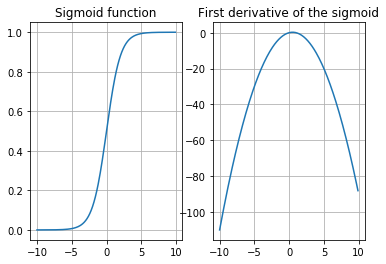

In [3]:
x = np.arange(-10, 10, 0.1)
plt.figure()
plt.subplot(121)
plt.plot(x, sigmoid(x)); plt.title("Sigmoid function"); plt.grid()
plt.subplot(122)
plt.plot(x, sigmoid_deriv(x)); plt.title("First derivative of the sigmoid"); plt.grid()


A neuron will take an input (the input can be an array), will multiply the input by a set of coefficients and will apply the result to the sigmoid function, the sigmoid will limit the output to a value between (0, 1)

In [4]:
class Neuron:
    def __init__(self, coeffs_len):
        """The legth of the vector coeffs defines the number of inputs.
        Initializes the coefficients to a random number between (-1,1)"""
        self.coeffs = 2*np.random.random((coeffs_len, 1)) - 1
        self.last_inputs = None
        self.last_output = None
    
    def forward(self, inputs):
        """Multiply the inputs by the coefficients and pass through the sigmoid function
        
           :params inputs a NxM vector where M is the number of parameters, N is the number
                   of inptus
           :return the activation value of the network
           :rtype array Nx1
        """

        if inputs.ndim == 1:
            inputs = inputs.reshape((1, inputs.shape[0]))
            
        self.last_inputs = inputs
        self.last_output = sigmoid(np.dot(inputs, self.coeffs))
        return self.last_output
    
    def backward(self, cost):
        """Update the coefficients based on how much error at the output, use the derivative
        of the sigmoid function to decide how to jump in the coefficient calculation
        
        :param cost the error of the last calculated value
        """
        delta = cost * sigmoid_deriv(self.last_output)
        self.coeffs += 0.5*np.dot(self.last_inputs.T, delta)/self.last_inputs.shape[0]



Let's create a simple model with three variables, and generate a set of input values and outputs for the model.
Then lets iteratively:
 - _forward propagate_ the inputs on the neuron
 - calculate the error between the calculated output and the expected output
 - compensate the offsets (applying _backwards propagation_)
    - use the derivative of the sigmoid function calculated in the points of the output to figure out on which direction to correct the coefficients, also by how much.
    - compensate the detivative by the error, i.e. correct more coefficients with larger error

estimated coefficients: [[ 3.0562741 ]
 [ 3.17853419]
 [ 2.13591174]]


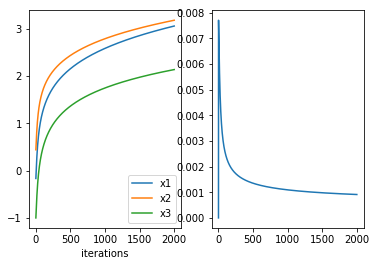

In [5]:
coeffs_sz = 3
N = Neuron(coeffs_sz)
    # y = 0.1*x1 + 0.3*x2 -0.1*x3

def model(x):
    coeffs = np.array([0.1, 0.01, -0.1])
    #return 1*(np.inner(x, coeffs) > 0)
    return np.inner(x, coeffs)

#assert( model(np.array([[1,2,3]])) - 0.4 < 0.001 )

sz = 1500
reps = 2000

def CalculateForNeuron(N, sz, reps, model):
    X = np.random.random((sz,3))-1
    Y = model(X).reshape((sz,1))

    model_coeffs = np.zeros((reps, N.coeffs.shape[0]))
    output_error = np.zeros(reps)

    model_coeffs[0] = N.coeffs.reshape((3,))
    for i in range(1, reps):
        output = N.forward(X)
        cost = Y - output
        output_error[i] = np.linalg.norm(cost, ord=2)/sz/2
        N.backward(cost)
        model_coeffs[i] = N.coeffs.reshape((3,))

    return (model_coeffs, output_error, X, Y)
        
model_coeffs, output_error, X, Y = CalculateForNeuron(N, sz, reps, model)
    
#print(output)
#print(Y)
print("estimated coefficients: {}".format(N.coeffs))

plt.figure()
plt.subplot(121)
plt.plot(model_coeffs); plt.xlabel("iterations"); plt.legend(["x1", "x2", "x3"])
plt.subplot(122)
plt.plot(output_error)


What we get is far from what we expected, the coefficients for the model are not being calculated but why?

There are several assumptions that I made that are not correct.

1. The neuron is a probabilistic model, i.e. the output is a probability (between 0 and 1), but the outputs of the model can take positive or negative values.

So what happens if I change the model into a function that calculates 0 if the output is negative and 1 if the output is positive:

estimated coefficients: [[ 5.65541224]
 [ 0.61570387]
 [-5.49037565]]


Text(0.5,1,'ChiSqr')

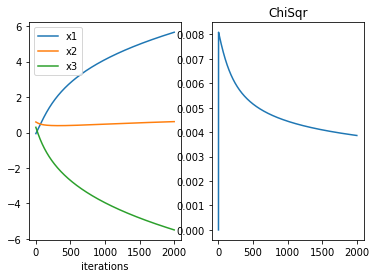

In [6]:
coeffs_sz = 3
N = Neuron(coeffs_sz)
    # y = (0.1*x1 + 0.3*x2 -0.1*x3) > 0

def model(x):
    coeffs = np.array([0.1, 0.01, -0.1])
    #return 1*(np.inner(x, coeffs) > 0)
    return (np.inner(x, coeffs) > 0 )

#assert( model(np.array([[1,2,3]])) - 0.4 < 0.001 )

sz = 1000
reps = 2000

model_coeffs, output_error, X, Y = CalculateForNeuron(N, sz, reps, model)
    
#print(output)
#print(Y)
print("estimated coefficients: {}".format(N.coeffs))

plt.figure()
plt.subplot(121)
plt.plot(model_coeffs); plt.xlabel("iterations"); plt.legend(["x1", "x2", "x3"])
plt.subplot(122)
plt.plot(output_error); plt.title("ChiSqr")


That looks better? Well in fact it does, the neuron is getting coefficients that fit the input to the output, the problem is that that there is an infinite set of coefficients that would fit the function.

As we can see if we normalize the coefficients we get:

normalized coefficients:
 [[ 1.        ]
 [ 0.10886985]
 [-0.97081794]]
normalized model coefficients:
 [ 1.   0.1 -1. ]


Text(0.5,0,'error')

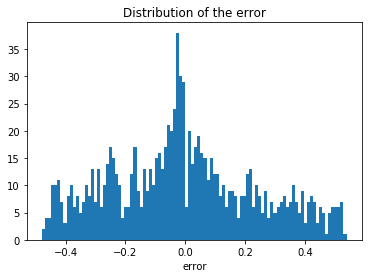

In [7]:
print("normalized coefficients:\n {}".format(N.coeffs/N.coeffs[0]))
print("normalized model coefficients:\n {}".format(np.array([0.1, 0.01, -0.1])/0.1))
plt.figure()
a=plt.hist(Y-N.last_output,bins=100);plt.title("Distribution of the error"); plt.xlabel("error")

But the error is not high but the coefficients are not correct.

So to _"take aways"_ so far:
- the neuron does probabilistic calculations
- the input and output values for the neuron need to be controlled

But there are more problems:
- the input is not normalize
- the input has not zero bias
- how can be push the coefficients into beeing smaller?

In any case why have I used a non-linear activation function? Let's rewrite the neuron to use a linear activation function. And this time lets also add bias to it.

\begin{equation}
f \left( \mathbf{x} \right) = \sum_{i} w_i * x_i + b_i
\end{equation}

In [8]:
class LinearNeuron:
    def __init__(self, coeffs_len):
        """The legth of the vector coeffs defines the number of inputs.
        Initializes the coefficients to a random number between (-1,1)"""
        self.coeffs = 2*np.random.random((coeffs_len, 1)) - 1
        self.last_inputs = None
        self.last_output = None
    
    def forward(self, inputs):
        """Multiply the inputs by the coefficients and pass through the sigmoid function
        
           :params inputs a NxM vector where M is the number of parameters, N is the number
                   of inptus
           :return the activation value of the network
           :rtype array Nx1
        """

        if inputs.ndim == 1:
            inputs = inputs.reshape((1, inputs.shape[0]))
            
        self.last_inputs = inputs
        self.last_output = np.dot(inputs, self.coeffs)
        return self.last_output
    
    def backward(self, cost):
        """Update the coefficients based on how much error at the output, use the derivative
        of the sigmoid function to decide how to jump in the coefficient calculation
        
        :param cost the error of the last calculated value
        """
        delta = cost * self.last_output
        self.coeffs += 0.5*np.dot(self.last_inputs.T, delta)/self.last_inputs.shape[0]

estimated coefficients: [[ inf]
 [ inf]
 [ inf]]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in multiply


Text(0.5,1,'ChiSqr')

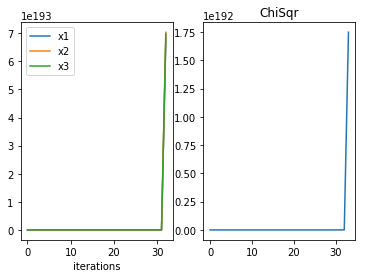

In [9]:
coeffs_sz = 3
N = LinearNeuron(coeffs_sz)
    # y = (0.1*x1 + 0.3*x2 -0.1*x3) > 0

def model(x):
    coeffs = np.array([0.1, 0.01, -0.1])
    return np.inner(x, coeffs)
    #return (np.inner(x, coeffs) > 0 )

#assert( model(np.array([[1,2,3]])) - 0.4 < 0.001 )

sz = 1000
reps = 2000

model_coeffs, output_error, X, Y = CalculateForNeuron(N, sz, reps, model)
    
#print(output)
#print(Y)
print("estimated coefficients: {}".format(N.coeffs))

plt.figure()
plt.subplot(121)
plt.plot(model_coeffs); plt.xlabel("iterations"); plt.legend(["x1", "x2", "x3"])
plt.subplot(122)
plt.plot(output_error); plt.title("ChiSqr")
